In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
from pathlib import Path
import os
import yaml
import pandas as pd
import requests
import tarfile
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, TypeVar, Union
from typing import Any, AnyStr, Callable, Collection, Dict, Hashable, Iterator, List, Mapping, NewType, Optional
import boto3
import hashlib
import shutil

In [ ]:
# export
class Config:
    config_path = Path(os.getenv('SHOTCHART_HOME', '~/.shot_chart')).expanduser()
    config_file = config_path/'config.yml'

    def __init__(self):
        self.config_path.mkdir(parents=True, exist_ok=True)
        if not self.config_file.exists(): self.create_config()
        self.d = self.load_config()

    def __getitem__(self,k):
        k = k.lower()
        if k not in self.d: k = k+'_path'
        if k in ["my_dpi","fig_height","fig_width"]:
            return self.d[k]
        return Path(self.d[k])

    def __getattr__(self,k):
        if k=='d': raise AttributeError
        return self[k]

    def __setitem__(self,k,v): self.d[k] = str(v)
    def __contains__(self,k): return k in self.d

    def load_config(self):
        with open(self.config_file, 'r') as f:
            config = yaml.safe_load(f)
            if 'version' in config and config['version'] == 1: return config
        self.create_config()
        return self.load_config()

    def create_config(self):
        F = plt.gcf()
        # Now check everything with the defaults:
        DPI = F.get_dpi()
        config = {'data_path':    str(self.config_path/'data'),
                  'archive_path':    str(self.config_path/'archive'),
                  'version':      1,
                  'my_dpi': DPI,
                  'fig_height': 472,
                  'fig_width': 500
                 }
        self.save_file(config)

    def save(self): self.save_file(self.d)
    def save_file(self, config):
        with self.config_file.open('w') as f: yaml.dump(config, f, default_flow_style=False)

In [ ]:
config = Config()

## URLs -

In [ ]:
# export
class URLs():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    S3 = 'https://nba-shot-charts.s3.amazonaws.com/'

    SHOTS_2000    = f'{S3}shots-2000.tgz'
    SHOTS_2001    = f'{S3}shots-2001.tgz'
    SHOTS_2002    = f'{S3}shots-2002.tgz'
    SHOTS_2003    = f'{S3}shots-2003.tgz'
    SHOTS_2004    = f'{S3}shots-2004.tgz'
    SHOTS_2005    = f'{S3}shots-2005.tgz'
    SHOTS_2006    = f'{S3}shots-2006.tgz'
    SHOTS_2007    = f'{S3}shots-2007.tgz'
    SHOTS_2008    = f'{S3}shots-2008.tgz'
    SHOTS_2009    = f'{S3}shots-2009.tgz'
    SHOTS_2010    = f'{S3}shots-2010.tgz'
    SHOTS_2011    = f'{S3}shots-2011.tgz'
    SHOTS_2012    = f'{S3}shots-2012.tgz'
    SHOTS_2013    = f'{S3}shots-2013.tgz'
    SHOTS_2014    = f'{S3}shots-2014.tgz'
    SHOTS_2015    = f'{S3}shots-2015.tgz'
    SHOTS_2016    = f'{S3}shots-2016.tgz'
    SHOTS_2017    = f'{S3}shots-2017.tgz'
    SHOTS_2018    = f'{S3}shots-2018.tgz'
    SHOTS_2019    = f'{S3}shots-2019.tgz'

    def path(url, c_key='archive'):
        fname = url.split('/')[-1]
        local_path = URLs.LOCAL_PATH/('data' if c_key=='data' else 'archive')/fname
        if local_path.exists(): return local_path
        return Config()[c_key]/fname

## Downloading

In [ ]:
# export
def download_url(url, dest, overwrite=False, pbar=None, show_progress=True, chunk_size=1024*1024,
                 timeout=4, retries=5):
    "Download `url` to `dest` unless it exists and not `overwrite`"
    if os.path.exists(dest) and not overwrite: return

    s = requests.Session()
    s.mount('http://',requests.adapters.HTTPAdapter(max_retries=retries))
    # additional line to identify as a firefox browser, see fastai/#2438
    s.headers.update({'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'})
    u = s.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: show_progress = False

    with open(dest, 'wb') as f:
        nbytes = 0
        if show_progress: pbar = progress_bar(range(file_size), leave=False, parent=pbar)
        try:
            if show_progress: pbar.update(0)
            for chunk in u.iter_content(chunk_size=chunk_size):
                nbytes += len(chunk)
                if show_progress: pbar.update(nbytes)
                f.write(chunk)
        except requests.exceptions.ConnectionError as e:
            fname = url.split('/')[-1]
            data_dir = dest.parent
            print(f'\n Download of {url} has failed after {retries} retries\n'
                  f' Fix the download manually:\n'
                  f'$ mkdir -p {data_dir}\n'
                  f'$ cd {data_dir}\n'
                  f'$ wget -c {url}\n'
                  f'$ tar xf {fname}\n'
                  f' And re-run your code once the download is successful\n')

In [ ]:
# export
def download_data(url, fname=None, c_key='archive', force_download=False):
    "Download `url` to `fname`."
    fname = Path(fname or URLs.path(url, c_key=c_key))
    fname.parent.mkdir(parents=True, exist_ok=True)
    if not fname.exists() or force_download: download_url(url, fname, overwrite=force_download)
    return fname

### Extract

In [ ]:
#export
def file_extract(fname, dest='.'):
    "Extract `fname` to `dest` using `tarfile` or `zipfile"
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

`file_extract` is used by default in `untar_data` to decompress the downloaded file.

In [ ]:
#export 
def _get_check(url):
    s3 = boto3.client('s3')
    s3_resp = s3.head_object(Bucket=URLs.S3.split(".")[0].split("//")[1],Key=url.split("/")[-1])
    ETag = s3_resp['ETag'].strip('"')
    # Open,close, read file and calculate MD5 on its contents 
    with open(Path(URLs.path(url)),"rb") as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        md5_returned = hashlib.md5(data).hexdigest()
    return ETag != md5_returned

In [ ]:
URLs.path(URLs.SHOTS_2019)

PosixPath('/Users/cesar.muro/.shot_chart/archive/shots-2019.tgz')

In [ ]:
_get_check(URLs.SHOTS_2019)

False

In [ ]:
#export
def untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=file_extract):
    "Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`."
#     default_dest = URLs.path(url, c_key=c_key).with_suffix('.csv')
    default_dest = URLs.path(url, c_key=c_key).with_suffix('.csv')
    dest = default_dest if dest is None else Path(dest)/default_dest.name
    fname = Path(fname or URLs.path(url))
#     if fname.exists() and _get_check(url) and _check_file(fname) != _get_check(url):
#         print("A new version of this dataset is available, downloading...")
#         force_download = True
    if fname.exists() and _get_check(url):
        print("A new version of this dataset is available, downloading...")
        force_download = True
    if force_download:
        if fname.exists(): os.remove(fname)
        if dest.exists(): os.remove(dest)
    if not dest.exists():
        fname = download_data(url, fname=fname, c_key=c_key)
#         if _get_check(url) and _check_file(fname) != _get_check(url):
#             print(f"File downloaded is broken. Remove {fname} and try again.")
        extract_func(fname, dest.parent)
    return dest

In [ ]:
#export
def make_df(path):
    "Creates a pandas df from `path`"
    return pd.read_csv(path)

In [ ]:
shots_2019 = make_df(untar_data(URLs.SHOTS_2019))

In [ ]:
shots_2019.head(50)

,Unnamed: 0,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,99,201910260ATL,2019,10,26,Atlanta,Orlando,168px,253px,"1st quarter, 11:47.0 remaining<br>Trae Young m...",11:47.0,1,Trae Young,made,2-pointer,14ft,Atlanta,2,0
1,0,201910260ATL,2019,10,26,Atlanta,Orlando,46px,232px,"1st quarter, 11:28.0 remaining<br>Aaron Gordon...",11:28.0,1,Aaron Gordon,missed,2-pointer,2ft,Orlando,2,0
2,1,201910260ATL,2019,10,26,Atlanta,Orlando,27px,240px,"1st quarter, 11:23.0 remaining<br>Aaron Gordon...",11:23.0,1,Aaron Gordon,made,2-pointer,1ft,Orlando,2,2
3,100,201910260ATL,2019,10,26,Atlanta,Orlando,216px,245px,"1st quarter, 11:10.0 remaining<br>Trae Young m...",11:10.0,1,Trae Young,made,2-pointer,18ft,Atlanta,4,2
4,101,201910260ATL,2019,10,26,Atlanta,Orlando,285px,177px,"1st quarter, 10:44.0 remaining<br>Alex Len mis...",10:44.0,1,Alex Len,missed,3-pointer,26ft,Atlanta,4,2
5,2,201910260ATL,2019,10,26,Atlanta,Orlando,264px,347px,"1st quarter, 10:26.0 remaining<br>Evan Fournie...",10:26.0,1,Evan Fournier,made,3-pointer,26ft,Orlando,4,5
6,102,201910260ATL,2019,10,26,Atlanta,Orlando,163px,227px,"1st quarter, 10:11.0 remaining<br>De'Andre Hun...",10:11.0,1,De'Andre Hunter,made,2-pointer,13ft,Atlanta,6,5
7,3,201910260ATL,2019,10,26,Atlanta,Orlando,253px,115px,"1st quarter, 9:59.0 remaining<br>Nikola Vučevi...",9:59.0,1,Nikola Vučević,missed,3-pointer,25ft,Orlando,6,5
8,103,201910260ATL,2019,10,26,Atlanta,Orlando,47px,234px,"1st quarter, 9:35.0 remaining<br>De'Andre Hunt...",9:35.0,1,De'Andre Hunter,made,2-pointer,2ft,Atlanta,8,5
9,4,201910260ATL,2019,10,26,Atlanta,Orlando,45px,237px,"1st quarter, 9:22.0 remaining<br>Nikola Vučevi...",9:22.0,1,Nikola Vučević,made,2-pointer,1ft,Orlando,8,7


### Creating a class - Shots

In [ ]:
#export
class Shots:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.__X_MODIFIER = 8
        self.__Y_MODIFIER = 466
        
    
    @property
    def teams(self):
        return self.dataframe['team'].drop_duplicates()
    
    @property
    def players(self):
#         if team:
#             return self.dataframe.loc[self.dataframe['team']==team]['shots_by'].drop_duplicates()
        return self.dataframe['shots_by'].drop_duplicates()

    @property
    def fg_pct(self):
        return self.__calculate_metric(self.dataframe,"fg")
    
    @property
    def efg_pct(self):
        #return ((fgm + 0.5 * three_pm)/fga)*100
        return self.__calculate_metric(self.dataframe,"efg")
    
    def __calculate_metric(self, dataframe, metric="efg"):
        if metric == "fg":
            return round(len(dataframe.loc[dataframe['outcome']=='made'])/len(dataframe),2)
        else:
            return round( (len(dataframe.loc[dataframe['outcome']=='made']) + 0.5 *len(dataframe.loc[(dataframe['outcome']=='made') & (dataframe['attempt']=='3-pointer')]))/len(dataframe),2)
    
    
    def plot_shots(self,date_range:Union[str,tuple,int]="all",made:bool=True,missed:bool=True,attempt:str="all", distance:Union[str,List[str]]="all"):
        "Plots the shot chart for `team` given a `date_range`"
        plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
        plt.subplot(1, 2, 1)
#         plt.title(team+ " shot chart")
        img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
        implot = plt.imshow(img, extent=[0,500,0,472])
        if date_range == "all":
            shots_df = self.dataframe
        elif type(date_range) == int:
            #means month
            shots_df = self.dataframe.loc[self.dataframe["month"]==date_range]
        else:
            #custom date range in the form of ((from_y,from_m,from_d),(to_y,to_m,to_d))
            from_index = self.dataframe[(self.dataframe["year"]==date_range[0][0]) & (self.dataframe["month"]==date_range[0][1]) & (self.dataframe["day"]==date_range[0][2])].index[0]
            to_index = self.dataframe[(self.dataframe["year"]==date_range[1][0]) & (self.dataframe["month"]==date_range[1][1]) & (self.dataframe["day"]==date_range[1][2])].index[0]
            shots_df = self.dataframe.iloc[[from_index,to_index]]
        if attempt == "2-pointer":
            if distance == "all":
                shots_df = shots_df.loc[shots_df["attempt"]=="2-pointer"]
            else:
                shots_df = shots_df.loc[(shots_df["attempt"]=="2-pointer") & (shots_df["distance"].isin(distance))]
        elif attempt == "3-pointer":
            if distance == "all":
                shots_df = shots_df.loc[shots_df["attempt"]=="3-pointer"]
            else:
                shots_df = shots_df.loc[(shots_df["attempt"]=="2-pointer") & (shots_df["distance"].isin(distance))]
        else:
            if distance == "all":
                shots_df = shots_df
            else:
                shots_df = shots_df.loc[shots_df["distance"].isin(distance)]
        #misses vs made
        if made:
            mades_df = shots_df.loc[shots_df['outcome']=='made']
            ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
            ys = [self.__Y_MODIFIER - int(x) for x in ys]
            xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
            xs = [x + self.__X_MODIFIER for x in xs]
            plt.scatter(xs,ys, color="g",alpha=1)
        if missed:
            misses_df = shots_df.loc[shots_df['outcome']=='missed']
            ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
            ys = [self.__Y_MODIFIER - int(x) for x in ys]
            xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
            xs = [x + self.__X_MODIFIER for x in xs]
            plt.scatter(xs,ys,marker="x", color="r",alpha=.5)
#         ax = plt.subplot(1, 2, 2)
#         distances = shots_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
#         plt.hist(distances,bins = 30)
#         ax.text(45, 1, "Metrics:\n FG%: "+str(self.fg_pct)+"\n eFG%: "+str(self.efg_pct), bbox=dict(facecolor='red', alpha=0.5))
        if made:
            ax = plt.subplot(1, 2, 2)
            distances = shots_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
            if type(distance) == list:
                plt.hist(distances,bins = len(distance))
                ax.text(len(distance) + 13, 1, "Metrics:\n FG%: "+str(self.fg_pct)+"\n eFG%: "+str(self.efg_pct), bbox=dict(facecolor='red', alpha=0.5))
            else:
                plt.hist(distances,bins = max(distances))
                ax.text(30 + 12, 1, "Metrics:\n FG%: "+str(self.fg_pct)+"\n eFG%: "+str(self.efg_pct), bbox=dict(facecolor='red', alpha=0.5))
        plt.show()
        
    def plot_effective(self, most_or_least="most",metric:str="efg", exclude:Union[str,List["str"]]="none"):
        distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
        distances = set(distances).intersection(set(self.dataframe['distance'].drop_duplicates().to_list()))
        if type(exclude) == list:
            distances = list(set(distances) - set(exclude))
#         distances = self.dataframe['distance'].drop_duplicates().to_list()
#         distances = list(set(distances) - set(distances_in_df))
        if most_or_least == "most":
            max_fg = -1
            max_efg = -1
            final_distance = ""
            for distance in distances:
                player_df = self.dataframe.loc[self.dataframe["distance"]==distance]
                fg_pct = self.__calculate_metric(player_df, "fg")
                efg_pct = self.__calculate_metric(player_df, "efg")
                if metric == "fg":
                    if fg_pct > max_fg:
                        max_fg = fg_pct
                        max_efg = efg_pct
                        final_distance = distance
                else:
                    if efg_pct > max_efg:
                        max_fg = fg_pct
                        max_efg = efg_pct
                        final_distance = distance
        else:
            max_fg = 101
            max_efg = 101
            final_distance = ""
            for distance in distances:
                player_df = self.dataframe.loc[self.dataframe["distance"]==distance]
                fg_pct = self.__calculate_metric(player_df, "fg")
                efg_pct = self.__calculate_metric(player_df, "efg")
                if metric == "fg":
                    if fg_pct < max_fg:
                        max_fg = fg_pct
                        max_efg = efg_pct
                        final_distance = distance
                else:
                    if efg_pct < max_efg:
                        max_fg = fg_pct
                        max_efg = efg_pct
                        final_distance = distance
        player_df = self.dataframe.loc[self.dataframe["distance"]==final_distance]
        plt.figure(figsize=(2*Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
        plt.subplot(1, 2, 1)
        img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
        implot = plt.imshow(img, extent=[0,500,0,472])
        mades_df = player_df.loc[player_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [self.__Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + self.__X_MODIFIER for x in xs]
        plt.scatter(xs,ys)
        misses_df = player_df.loc[player_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [self.__Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + self.__X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x")
        ax = plt.subplot(1, 2, 2)
        #I would still like to see the whole overall volume
        all_shots = self.dataframe
        distances = all_shots['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
        if type(exclude) == list:
            plt.hist(distances,bins = 31 - len(exclude))
            ax.text((31 - len(exclude)) + 15, 1, most_or_least+" effective shot: "+str(final_distance)+"\nMetrics:\n FG%: "+str(max_fg)+"\n eFG%: "+str(max_efg), bbox=dict(facecolor='red', alpha=0.5))
        else:
            plt.hist(distances,bins = max(distances))
            ax.text(30 + 12, 1, most_or_least+" effective shot: "+str(final_distance)+"\n\nMetrics:\n FG%: "+str(max_fg)+"\n eFG%: "+str(max_efg), bbox=dict(facecolor='red', alpha=0.5))
        plt.show()

In [ ]:
shots = Shots(shots_2019)

In [ ]:
shots.players

0              Trae Young
1            Aaron Gordon
4                Alex Len
5           Evan Fournier
6         De'Andre Hunter
               ...       
149186     Chasson Randle
150693      Jarrod Uthoff
152069           Miye Oni
154039        Joe Chealey
159689      Dusty Hannahs
Name: shots_by, Length: 510, dtype: object

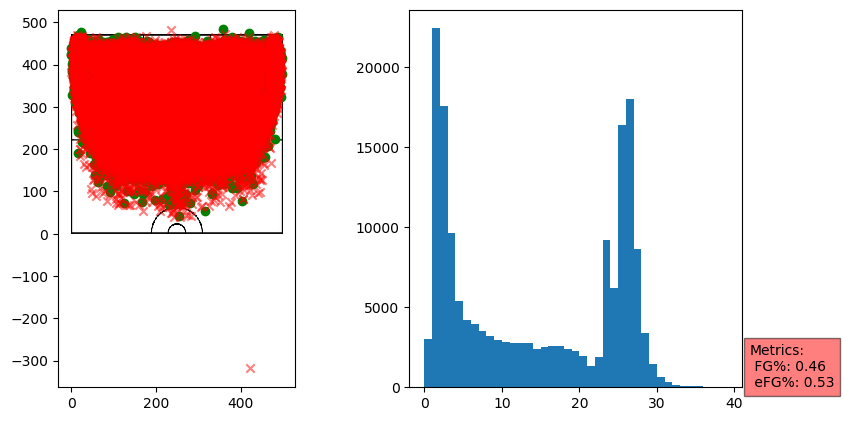

In [ ]:
shots.plot_shots()

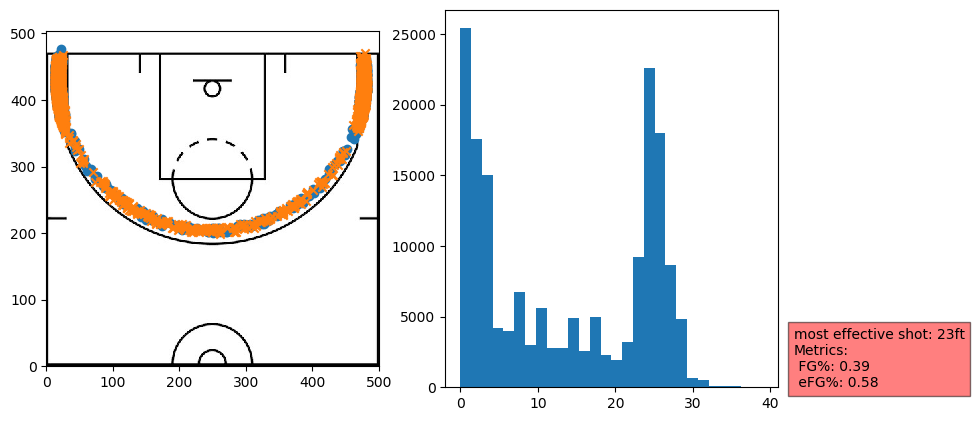

In [ ]:
shots.plot_effective(most_or_least="most", exclude=['0ft','1ft','2ft'])

## List teams

In [ ]:
#export
def list_teams(df):
    "Lists all the teams that play in one season"
    return df['team'].drop_duplicates()

In [ ]:
print(list_teams(shots_2019))

0            Atlanta
1            Orlando
183       Sacramento
184             Utah
341         Oklahoma
343     Golden State
511           Denver
512      New Orleans
675        Milwaukee
1016        Portland
1224         Phoenix
1226        Brooklyn
1412     San Antonio
1413         Memphis
1934         Toronto
2119    Philadelphia
2296       Minnesota
2477       LA Lakers
2655         Houston
2656     LA Clippers
2843       Charlotte
3017          Boston
3018      Washington
3383         Detroit
3918           Miami
5020       Cleveland
5535         Indiana
6407        New York
6410         Chicago
8473          Dallas
Name: team, dtype: object


## List unique game ids

In [ ]:
#export
def list_game_ids(df,year,month,day):
    "Lists unique game ids for a given date"
    return df.loc[(df['year']==year) & (df['month']==month) & (df['day']==day)][['game_id','winner','loser']].drop_duplicates()
    

In [ ]:
list_game_ids(shots_2019,2019,11,25)

,game_id,winner,loser
40400,201911250ATL,Minnesota,Atlanta
41460,201911250TOR,Toronto,Philadelphia
41631,201911250SAS,LA Lakers,San Antonio
41979,201911250MIL,Milwaukee,Utah
42161,201911250MIA,Miami,Charlotte
42325,201911250IND,Indiana,Memphis
42516,201911250GSW,Oklahoma City,Golden State
43049,201911250DET,Detroit,Orlando
43212,201911250CLE,Brooklyn,Cleveland
45560,201911250CHI,Portland,Chicago


## Inheriting from Shots to create TeamShots

In [ ]:
#export
class TeamShots(Shots):
    def __init__(self, dataframe, team, game_id=None):
        if game_id:
            dataframe = dataframe.loc[(dataframe['team']==team) & (dataframe['game_id']==game_id)]
        else:
            dataframe = dataframe.loc[dataframe['team']==team]
        self.team = team
        super().__init__(dataframe)

In [ ]:
team_shots = TeamShots(shots_2019,"Portland","201911250CHI")

In [ ]:
team_shots.team

'Portland'

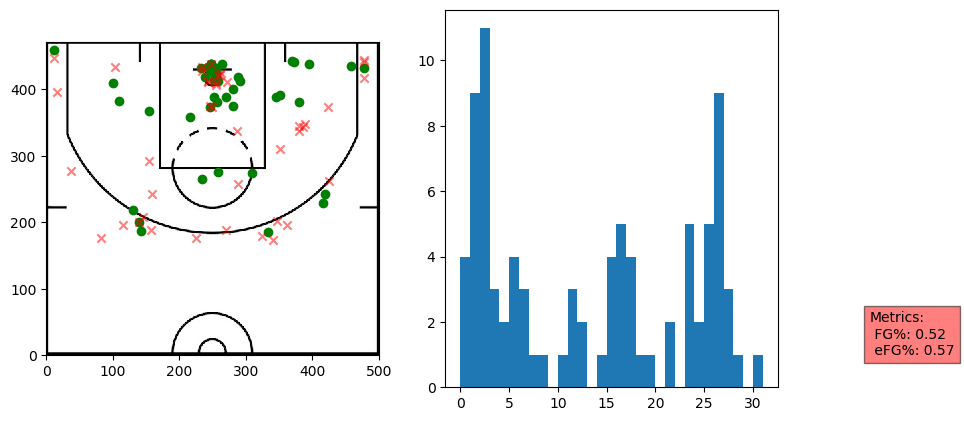

In [ ]:
team_shots.plot_shots()

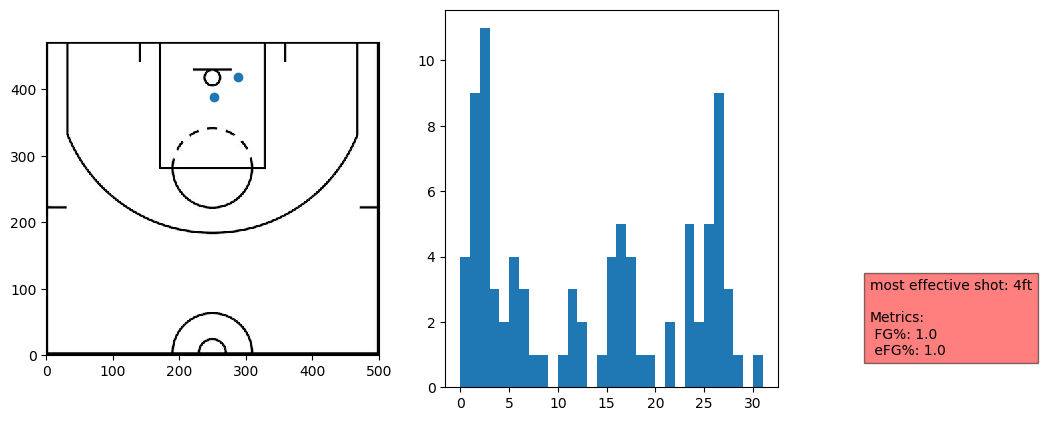

In [ ]:
team_shots.plot_effective()

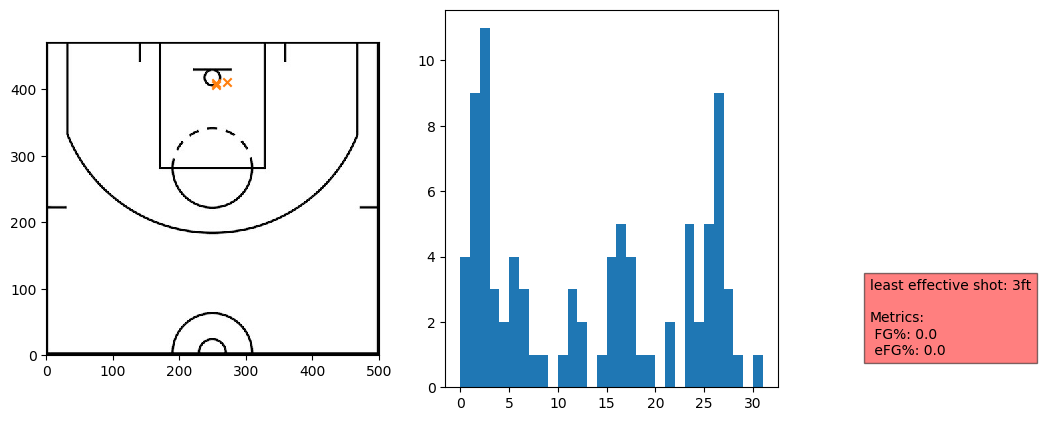

In [ ]:
team_shots.plot_effective(most_or_least="least")

In [ ]:
team_shots = TeamShots(shots_2019,"Houston")

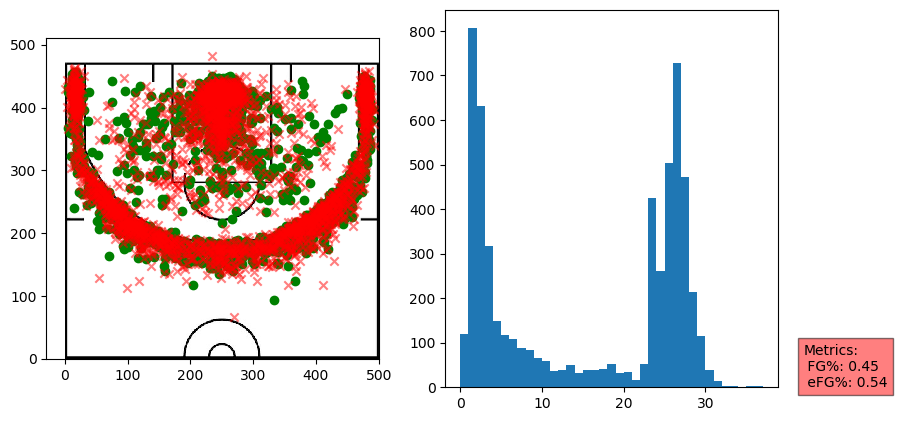

In [ ]:
team_shots.plot_shots()

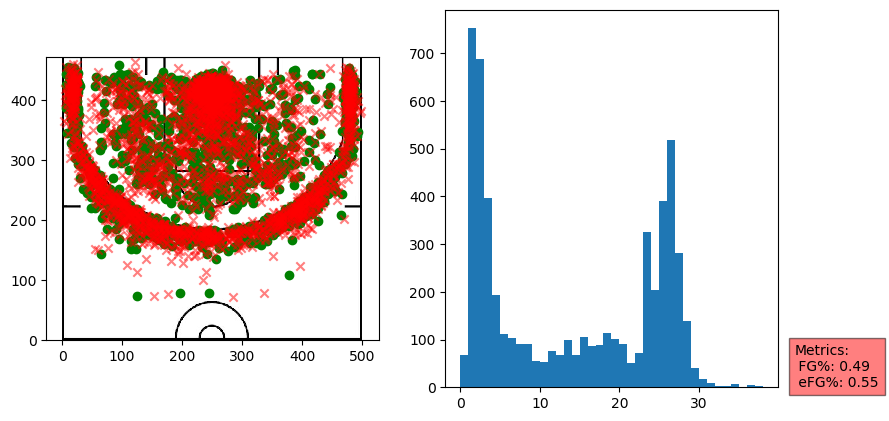

In [ ]:
team_shots = TeamShots(shots_2019,"LA Lakers")
team_shots.plot_shots()

## List players who took shots for a team

In [ ]:
#export
def list_team_players(df, team):
    return df.loc[df['team']==team].groupby('shots_by').shots_by.count().reset_index(name='count').sort_values(['count'], ascending=False)

In [ ]:
list_team_players(shots_2019,'LA Lakers')

,shots_by,count
9,LeBron James,1175
1,Anthony Davis,990
8,Kyle Kuzma,585
7,Kentavious Caldwell-Pope,465
3,Danny Green,425
2,Avery Bradley,382
12,Rajon Rondo,327
5,JaVale McGee,282
0,Alex Caruso,259
4,Dwight Howard,257


### Inheriting from Shots to create PlayerShots

In [ ]:
#export
class PlayerShots(Shots):
    def __init__(self, dataframe, player, game_id = None):
        if game_id:
            dataframe = dataframe.loc[(dataframe['shots_by']==player) & (dataframe['game_id']==game_id)]
        else:
            dataframe = dataframe.loc[dataframe['shots_by']==player]
        self.player = player
        super().__init__(dataframe)

In [ ]:
player_shots = PlayerShots(shots_2019,"Anthony Davis")

In [ ]:
player_shots.fg_pct

0.51

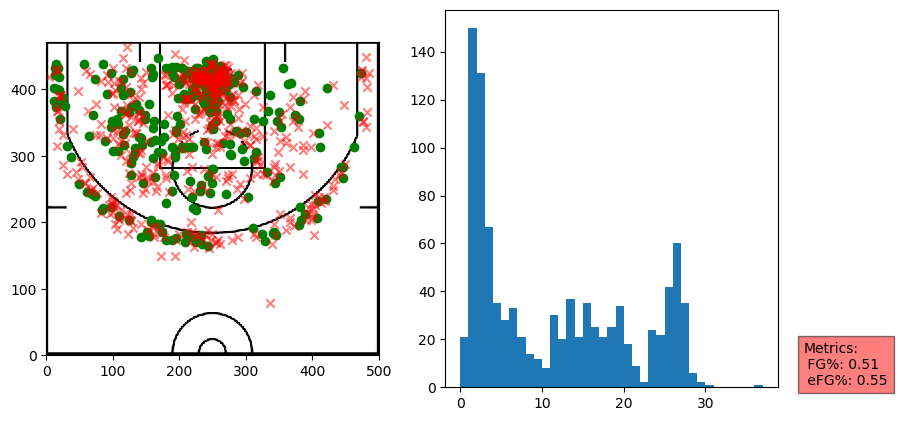

In [ ]:
player_shots.plot_shots()

In [ ]:
player_shots = PlayerShots(shots_2019,"D'Angelo Russell")

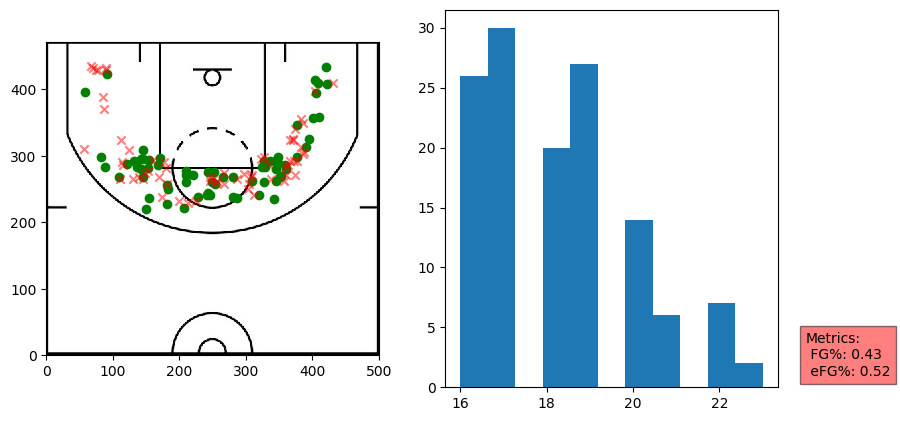

In [ ]:
player_shots.plot_shots(distance=["16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft"],attempt="2-pointer")

In [ ]:
list_game_ids(shots_2019, 2019, 12,1)

,game_id,winner,loser
49383,201912010BRK,Miami,Brooklyn
49569,201912010NYK,Boston,New York
49738,201912010TOR,Toronto,Utah
49918,201912010NOP,Oklahoma City,New Orleans
50086,201912010ORL,Orlando,Golden State
50264,201912010MIN,Memphis,Minnesota
50449,201912010LAL,Dallas,LA Lakers
50804,201912010LAC,LA Clippers,Washington
50998,201912010DET,Detroit,San Antonio


In [ ]:
player_shots = PlayerShots(shots_2019, 'Derrick Rose', '201912010DET')

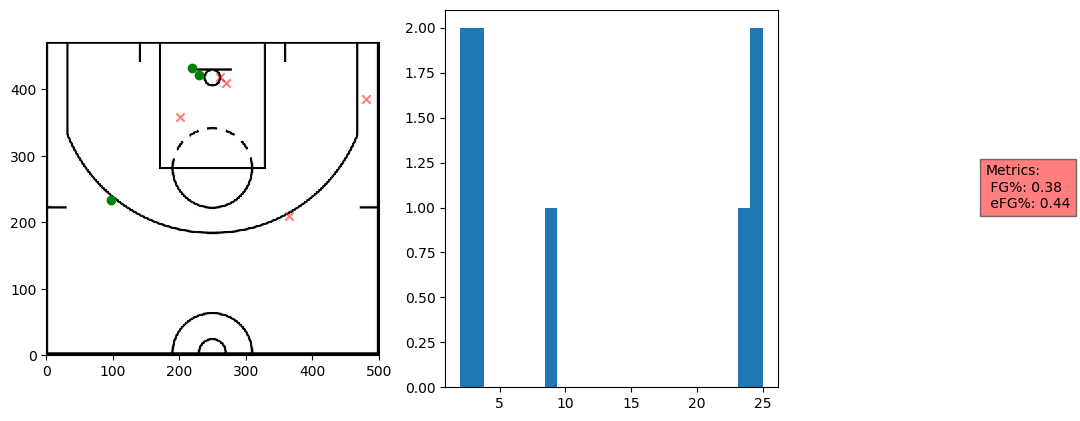

In [ ]:
player_shots.plot_shots()

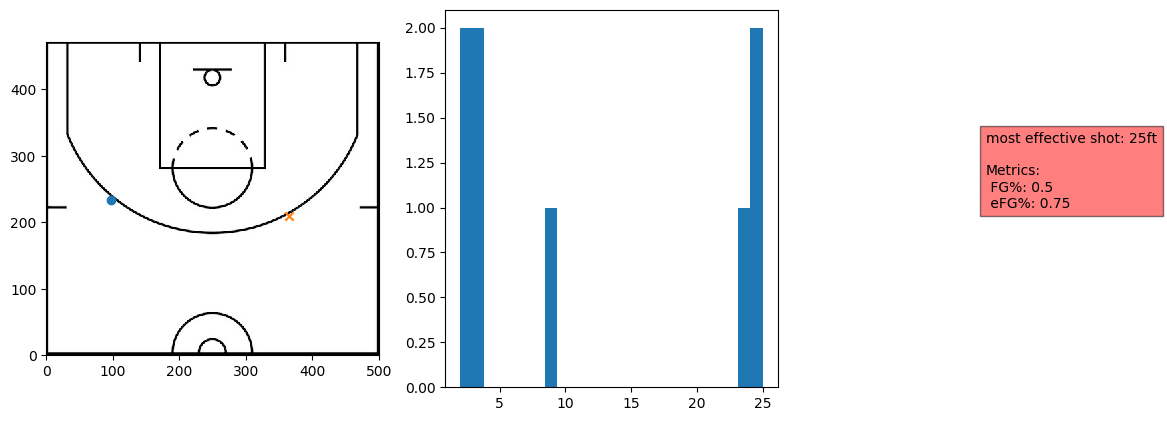

In [ ]:
player_shots.plot_effective()

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
